In [2]:
import theano.tensor as T 
import theano
import numpy
from theano.tensor.nnet import relu,conv2d
import h5py
from theano.tensor.signal.pool import pool_2d
import numpy as np
import scipy.optimize
import skimage.transform
%matplotlib inline
import matplotlib.pyplot as plt

Using gpu device 0: GRID K520 (CNMeM is disabled, cuDNN 5005)


In [2]:
class ConvLayer(object):
	"""Convolutional layer"""

	def __init__(self, rng, input, filter_shape, image_shape, W=None, b=None, padding=(1,1)):
		"""
		Allocate a LeNetConvPoolLayer with shared variable internal parameters.

		:type rng: numpy.random.RandomState
		:param rng: a random number generator used to initialize weights

		:type input: theano.tensor.dtensor4
		:param input: symbolic image tensor, of shape image_shape

		:type filter_shape: tuple or list of length 4
		:param filter_shape: (number of filters, num input feature maps,
		                      filter height, filter width)

		:type W: in accordance to filter_shape
		:param: use pretrained VGG weights

		:type b: (filter_shape[0],)
		:param: use pretrained vgg weights

		:type image_shape: tuple or list of length 4
		:param image_shape: (batch size, num input feature maps,
		                     image height, image width)

		:type padding: tuple or list of length 2
		:param padding: padding for conv
		"""

		#assert image_shape[1] == filter_shape[1]
		#self.input = input

		if W is None:
			# there are "num input feature maps * filter height * filter width"
			# inputs to each hidden unit
			fan_in = numpy.prod(filter_shape[1:])
			# each unit in the lower layer receives a gradient from:
			# "num output feature maps * filter height * filter width" /
			#   pooling size
			fan_out = (filter_shape[0] * numpy.prod(filter_shape[2:]))
			# initialize weights with random weights
			W_bound = numpy.sqrt(6. / (fan_in + fan_out))
			self.W = theano.shared(
			    numpy.asarray(
			        rng.uniform(low=-W_bound, high=W_bound, size=filter_shape),
			        dtype=theano.config.floatX), borrow=True)
		else:
			self.W = theano.shared(W,borrow=True)

		if b is None:
			# the bias is a 1D tensor -- one bias per output feature map
			b_values = numpy.zeros((filter_shape[0],), dtype=theano.config.floatX)
			self.b = theano.shared(value=b_values, borrow=True)
		else:
			self.b = theano.shared(b,borrow=True)
        # convolve input feature maps with filters
		conv_out = conv2d(
		    input=input,
		    filters=self.W,
		    filter_shape=filter_shape,
		    input_shape=image_shape,
		    border_mode=padding
		)

		# add the bias term. Since the bias is a vector (1D array), we first
		# reshape it to a tensor of shape (1, n_filters, 1, 1). Each bias will
		# thus be broadcasted across mini-batches and feature map
		# width & height
		self.output = relu(conv_out + self.b.dimshuffle('x', 0, 'x', 'x'))

In [4]:
#function to convert image into vgg model compatible format
def prep_image(im):
    MEAN_VALUES = np.array([104, 117, 123]).reshape((3,1,1))
    #if it is gray
    if len(im.shape) == 2:
        im = im[:, :, np.newaxis]
        im = np.repeat(im, 3, axis=2)
    h, w, _ = im.shape
    rawim = np.copy(im).astype('uint8')

    im = np.swapaxes(np.swapaxes(im, 1, 2), 0, 1)
    
    im = im[::-1, :, :]

    im = im - MEAN_VALUES
    return rawim, np.float32(im[np.newaxis])

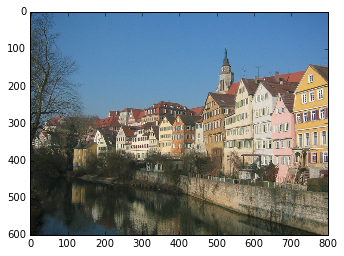

In [5]:
#load content image
content_image = plt.imread("content_image.jpg")
shape = content_image.shape
rawim, content_image = prep_image(content_image)
plt.imshow(rawim)

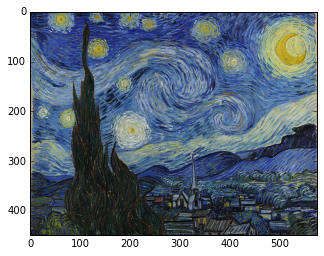

In [7]:
#load style image
style_image = plt.imread('style_image.jpg')
#style_image = skimage.transform.resize(style_image,shape, preserve_range=True)
rawim, style_image = prep_image(style_image)
plt.imshow(rawim)

In [6]:
x = T.tensor4('image')
mode='average_exc_pad'

#load the weights data
vgg_weights = h5py.File("vgg19_weights.h5")
#build the model
rng = numpy.random.RandomState(8888)
g = vgg_weights['layer_1']
conv1_1 = ConvLayer(rng=rng, input=x, filter_shape=(64,3,3,3), image_shape=None, 
	W=g['param_0'].value ,b=g['param_1'].value, padding=(1,1))
g = vgg_weights['layer_3']
conv1_2 = ConvLayer(rng=rng, input=conv1_1.output,filter_shape=(64,64,3,3), image_shape=None,
	W=g['param_0'].value,b=g['param_1'].value, padding=(1,1))
conv1_pool = pool_2d(conv1_2.output,ds=(2,2),padding=(0,0),mode=mode,ignore_border=True)

g = vgg_weights['layer_6']
conv2_1 = ConvLayer(rng=rng, input=conv1_pool, filter_shape=(128,64,3,3), image_shape=None, 
	W=g['param_0'].value ,b=g['param_1'].value, padding=(1,1))
g = vgg_weights['layer_8']
conv2_2 = ConvLayer(rng=rng, input=conv2_1.output, filter_shape=(128,128,3,3), image_shape=None, 
	W=g['param_0'].value ,b=g['param_1'].value, padding=(1,1))
conv2_pool = pool_2d(conv2_2.output,ds=(2,2),padding=(0,0),mode=mode,ignore_border=True)

g = vgg_weights['layer_11']
conv3_1 = ConvLayer(rng=rng, input=conv2_pool, filter_shape=(256,128,3,3), image_shape=None, 
	W=g['param_0'].value ,b=g['param_1'].value, padding=(1,1))
g = vgg_weights['layer_13']
conv3_2 = ConvLayer(rng=rng, input=conv3_1.output, filter_shape=(256,256,3,3), image_shape=None, 
	W=g['param_0'].value ,b=g['param_1'].value, padding=(1,1))
g = vgg_weights['layer_15']
conv3_3 = ConvLayer(rng=rng, input=conv3_2.output, filter_shape=(256,256,3,3), image_shape=None, 
	W=g['param_0'].value ,b=g['param_1'].value, padding=(1,1))
g = vgg_weights['layer_17']
conv3_4 = ConvLayer(rng=rng, input=conv3_3.output, filter_shape=(256,256,3,3), image_shape=None, 
	W=g['param_0'].value ,b=g['param_1'].value, padding=(1,1))
conv3_pool = pool_2d(conv3_4.output,ds=(2,2),padding=(0,0),mode=mode,ignore_border=True)

g = vgg_weights['layer_20']
conv4_1 = ConvLayer(rng=rng, input=conv3_pool, filter_shape=(512,256,3,3), image_shape=None, 
	W=g['param_0'].value ,b=g['param_1'].value, padding=(1,1))
g = vgg_weights['layer_22']
conv4_2 = ConvLayer(rng=rng, input=conv4_1.output, filter_shape=(512,512,3,3), image_shape=None, 
	W=g['param_0'].value ,b=g['param_1'].value, padding=(1,1))
g = vgg_weights['layer_24']
conv4_3 = ConvLayer(rng=rng, input=conv4_2.output, filter_shape=(512,512,3,3), image_shape=None, 
	W=g['param_0'].value ,b=g['param_1'].value, padding=(1,1))
g = vgg_weights['layer_26']
conv4_4 = ConvLayer(rng=rng, input=conv4_3.output, filter_shape=(512,512,3,3), image_shape=None, 
	W=g['param_0'].value ,b=g['param_1'].value, padding=(1,1))
conv4_pool = pool_2d(conv4_4.output,ds=(2,2),padding=(0,0),mode=mode,ignore_border=True)

g = vgg_weights['layer_29']
conv5_1 = ConvLayer(rng=rng, input=conv4_pool, filter_shape=(512,512,3,3), image_shape=None, 
	W=g['param_0'].value ,b=g['param_1'].value, padding=(1,1))


In [7]:
#give an matrix, return its gram_matrix
def gram_matrix(k):
    k = k.flatten(3)
    g = T.tensordot(k, k, axes=([2], [2]))
    return g
#content loss
def content_loss(p, X):
    im = X[-1]
    loss = 1./2 * ((im - p)**2).sum()
    return loss
#style loss
def style_loss(style_features, output_features):
    global weights
    losses = []
    for i in xrange(len(style_features)):
        a = style_features[i]
        b = output_features[i]
        
        G = gram_matrix(a)
        A = gram_matrix(b)
        
        N = a.shape[1]
        M = a.shape[2] * b.shape[3]

        losses.append(1./(4 * N**2 * M**2) * T.sum((G - A)**2)*weights[i])
    return T.sum(losses)
#works as an regularizer
def total_variation_loss(im):
    return (((im[:,:,:-1,:-1] - im[:,:,1:,:-1])**2 + (im[:,:,:-1,:-1] - im[:,:,:-1,1:])**2)**1.25).sum()

In [27]:
# Helper functions to user scipy.optimize
def eval_loss(x0):
    x0 = np.float32(x0.reshape(content_image.shape))
    output_image.set_value(x0)
    return f_loss(output_image.get_value()).astype('float64')

#helper function for use scipy
def eval_grad(x0):
    x0 = np.float32(x0.reshape(content_image.shape))
    output_image.set_value(x0)
    return np.array(f_grad(output_image.get_value())).flatten().astype('float64')

#this function is used to reconstructe image
MEAN_VALUES = np.array([104, 117, 123]).reshape((3,1,1))
def deprocess(x):
    x = np.copy(x[0])
    x += MEAN_VALUES

    x = x[::-1]
    x = np.swapaxes(np.swapaxes(x, 0, 1), 1, 2)
    
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [59]:
#input noise image
shape = content_image.shape
noise = np.random.randint(0,2,size=(1,1,shape[2],shape[3]))*128
noise = np.repeat(noise,3,axis=1)
output_image = theano.shared(numpy.asarray(noise,dtype='float32'),borrow=True)

In [60]:
#accordding to our test, we find conv4_1 will damage the result, so we ignore conv4_1
style_layers = [conv1_1,conv2_1,conv3_1,conv5_1]
#this weight is based on our observation that, style element in conv5_1 is lack in result, so we increase its weight
weights = [1,50,50,100]
content_layers = conv4_2

f1 = theano.function(inputs=[x],outputs=[content_layers.output],allow_input_downcast=True)
photo_features = theano.shared(numpy.asarray(f1(numpy.asarray(content_image,
	dtype='float32'))[0],dtype='float32'))

In [61]:
#get result for style image
style_features = []
for conv in style_layers:
	f = theano.function(inputs=[x],outputs=[conv.output],allow_input_downcast=True)
	style_features.append(theano.shared(numpy.asarray(f(numpy.asarray(style_image,
		dtype='float32'))[0],dtype='float32')))

In [62]:
#get symbolic expression for noise image
output_features = []
style_layers.append(content_layers)
output_features = [conv.output for conv in style_layers]

In [73]:
#compute the cost for this input
alpha = 0.00005
beta = 10
var = 0.5e-6

cost = alpha*content_loss(photo_features,output_features) + \
			beta*style_loss(style_features,output_features) + \
			var*total_variation_loss(output_image)

In [74]:
#get the symbolic expression for grad, and create helper function for further using scipy optimizer
grad = T.grad(cost, x)
f_loss = theano.function([x], cost, allow_input_downcast=True)
f_grad = theano.function([x], grad, allow_input_downcast=True)
f_all_loss = theano.function([x],[alpha*content_loss(photo_features,output_features),
                                  beta*style_loss(style_features,output_features),
                                  var*total_variation_loss(x)])

In [ ]:
#save the result in a list, for analyzing the transform process
x0 = output_image.get_value().astype('float64')
xs = []
xs.append(x0)

# Optimize loop
for i in range(50):
    print(i)
    scipy.optimize.fmin_l_bfgs_b(eval_loss, x0.flatten(), fprime=eval_grad, maxfun=40)
    x0 = output_image.get_value().astype('float64')
    print f_loss(output_image.get_value()),f_all_loss(output_image.get_value())
    xs.append(x0)
#the printout information includes, total_loss,content_loss,style_loss,variation_loss

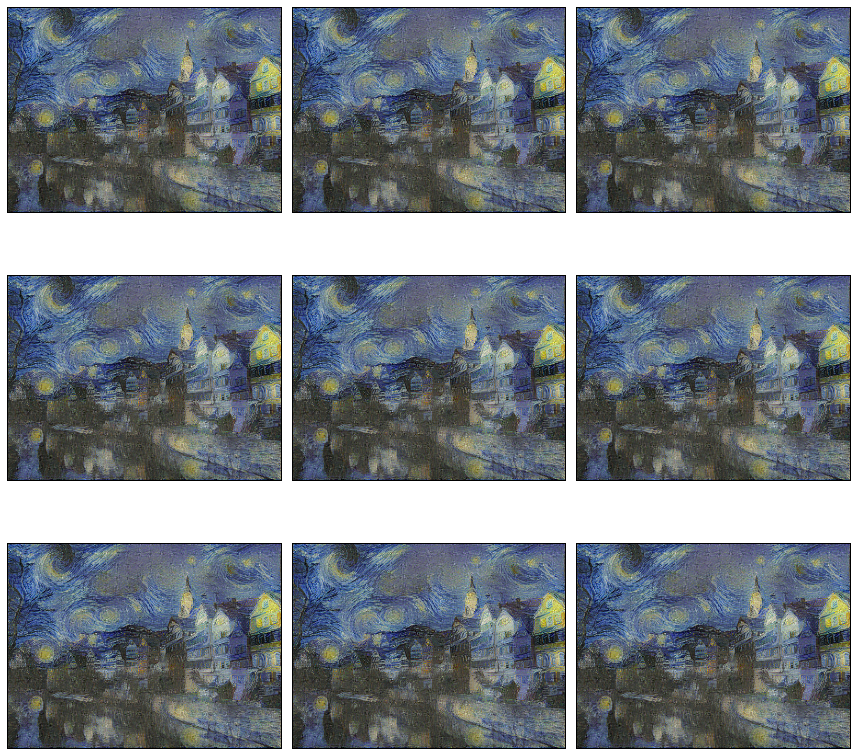

In [80]:
#plot the result
plt.figure(figsize=(12,12))
for i in range(len(xs)):
    if i>=len(xs) or i>8:
        break
    plt.subplot(3, 3, i+1)
    plt.gca().xaxis.set_visible(False)    
    plt.gca().yaxis.set_visible(False)    
    plt.imshow(deprocess(xs[-i]))
plt.tight_layout()

In [81]:
#save the best one
plt.imsave('star.png',deprocess(xs[-1]))

In [30]:
#save result for report
from PIL import Image
%matplotlib inline
import matplotlib.pyplot as plt

In [127]:
im = Image.new("RGB", (875, 675), "white")
imm = Image.new("RGB",(225,310),'white')
im1 = Image.open('red.jpg')
im2 = Image.open('style_image2.jpg')
im2.thumbnail((300,300), Image.ANTIALIAS)
imm.paste(im2,(0,10))
im.paste(im1,(75,0))
im.paste(imm,(0,400))

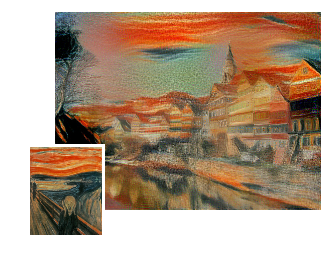

In [128]:
plt.axis('off')
plt.imshow(im)